In [192]:
#read in data files

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


df_app = pd.read_csv('Data Files/appearances.csv')
df_club_games = pd.read_csv('Data Files/club_games.csv')
df_clubs = pd.read_csv('Data Files/clubs.csv')
df_competitions = pd.read_csv('Data Files/competitions.csv')
df_game_events = pd.read_csv('Data Files/game_events.csv')
df_games = pd.read_csv('Data Files/games.csv')
df_player_val = pd.read_csv('Data Files/player_valuations.csv')
df_players = pd.read_csv('Data Files/players.csv')
df_country_mapping = pd.read_csv('Data Files/country_mapping.csv')


In [193]:
df_app = pd.merge(df_app, df_games[["game_id", "season"]], on="game_id")
df_app["date"] = pd.to_datetime(df_app["date"])
df_app["month"] = df_app["date"].dt.month
df_app_sub = df_app[df_app["month"]<6]

# Assuming df is your DataFrame
grouped_df = df_app_sub.groupby(['player_id', 'season']).apply(lambda x: x.loc[x['date'].idxmax()])

grouped_df.reset_index(drop=True, inplace=True)

grouped_df.head()


,appearance_id,game_id,player_id,player_club_id,player_current_club_id,date,player_name,competition_id,yellow_cards,red_cards,goals,assists,minutes_played,season,month
0,2478963_10,2478963,10,398,398,2015-05-31,Miroslav Klose,IT1,0,0,1,0,13,2014,5
1,2604347_10,2604347,10,398,398,2016-05-15,Miroslav Klose,IT1,0,0,1,0,90,2015,5
2,2460924_26,2460924,26,16,16,2015-05-23,Roman Weidenfeller,L1,0,0,0,0,90,2014,5
3,2675308_26,2675308,26,16,16,2016-04-14,Roman Weidenfeller,EL,0,0,0,0,90,2015,4
4,2704466_26,2704466,26,16,16,2017-01-21,Roman Weidenfeller,L1,0,0,0,0,90,2016,1


In [194]:
#preparation of player valuation on a saison basis - valuation date is the last valuation before August each year
df_player_val["date"] = pd.to_datetime(df_player_val["date"])
df_player_val["year"] = df_player_val["date"].dt.year
df_player_val["month"] = df_player_val["date"].dt.month
df_player_val = df_player_val[df_player_val["month"]<8]
df_player_val["season"] =df_player_val["year"] - 1

df_val_agg = df_player_val.groupby(['player_id', 'season']).agg({'date': 'max'})
df_val_agg = pd.merge(df_val_agg, df_player_val[["player_id", "season", "market_value_in_eur", "date"]], 
                      on=["player_id", "season", "date"])

In [195]:
# Preparing the data for correlation analysis

# Step 1: Aggregate appearance data for each player
# Aggregating goals, assists, yellow cards, red cards, and minutes played
df_app_agg = df_app.groupby(['player_id', 'season']).agg(
    total_goals=pd.NamedAgg(column='goals', aggfunc='sum'),
    total_assists=pd.NamedAgg(column='assists', aggfunc='sum'),
    total_yellow_cards=pd.NamedAgg(column='yellow_cards', aggfunc='sum'),
    total_red_cards=pd.NamedAgg(column='red_cards', aggfunc='sum'),
    total_minutes_played=pd.NamedAgg(column='minutes_played', aggfunc='sum')
).reset_index()

# Step 2: Merge player valuations with player data
merged_df = pd.merge(df_players, df_val_agg[['player_id', 'market_value_in_eur', 'season']],
                    on='player_id')



In [196]:
# Step 3: Merge the appearance data with the merged player data
final_df = pd.merge(merged_df, df_app_agg, on=['player_id', 'season'], how='left')
final_df = pd.merge(final_df, grouped_df[["player_id", "player_club_id", "season"]], on=['player_id', 'season'])
final_df = pd.merge(final_df, df_clubs[["club_id", "domestic_competition_id"]], left_on='player_club_id', right_on="club_id")


# Display the first few rows of the final merged DataFrame
final_df.head()

,player_id,first_name,last_name,name,last_season,current_club_id,player_code,country_of_birth,city_of_birth,country_of_citizenship,...,market_value_in_eur_y,season,total_goals,total_assists,total_yellow_cards,total_red_cards,total_minutes_played,player_club_id,club_id,domestic_competition_id
0,597,Aleksandr,Hleb,Aleksandr Hleb,2016,2696,aleksandr-hleb,UdSSR,Minsk,Belarus,...,750000,2014,2.0,4.0,1.0,0.0,2021.0,820,820,TR1
1,597,Aleksandr,Hleb,Aleksandr Hleb,2016,2696,aleksandr-hleb,UdSSR,Minsk,Belarus,...,400000,2015,0.0,0.0,1.0,0.0,1069.0,820,820,TR1
2,33796,Doga,Kaya,Doga Kaya,2015,820,doga-kaya,Turkey,Ankara,Turkey,...,500000,2014,0.0,0.0,13.0,0.0,1745.0,820,820,TR1
3,33796,Doga,Kaya,Doga Kaya,2015,820,doga-kaya,Turkey,Ankara,Turkey,...,200000,2015,0.0,0.0,2.0,0.0,820.0,820,820,TR1
4,50384,Etien,Velikonja,Etien Velikonja,2017,403,etien-velikonja,Jugoslawien (SFR),Sempeter pri Gorici,Slovenia,...,500000,2016,1.0,0.0,0.0,0.0,469.0,820,820,TR1


In [197]:
final_df["age_in_season"] = final_df["season"] + 1 - pd.to_datetime(final_df["date_of_birth"]).dt.year

In [198]:
columns_to_drop = ['player_id', 'first_name', 'last_name', 'name', 'last_season',
       'current_club_id', 'player_code', 'country_of_birth', 'city_of_birth', 'sub_position',
       'market_value_in_eur_x',
       'highest_market_value_in_eur', 'contract_expiration_date',
       'image_url', 'url', 'current_club_domestic_competition_id',
       'current_club_name',
       'player_club_id', 'date_of_birth']

final_df = final_df.drop(columns=columns_to_drop, axis=1)

In [199]:
final_df = final_df.rename(columns={'market_value_in_eur_y': 'market_value_in_eur'})

In [200]:
#try correlation once with dropped agent name due to large amounts of missing data, and once with dropped nan 
#values for agent name

#df1
df_no_agent_name = final_df.drop(columns=["agent_name"], axis=1)
df_final1 = df_no_agent_name.dropna()

#df2
df_final2 = final_df.dropna()

In [201]:
# Split the 'column_to_split' into 2 new columns
df_country_mapping[['country_of_citizenship', 'Continent']] = df_country_mapping['country_of_citizenship;Continent'].str.split(';', expand=True)

df_country_mapping.head()

,country_of_citizenship;Continent,country_of_citizenship,Continent
0,Afghanistan;Middle East,Afghanistan,Middle East
1,Albania;Eastern Europe,Albania,Eastern Europe
2,Algeria;Africa,Algeria,Africa
3,Andorra;Western Europe,Andorra,Western Europe
4,Angola;Africa,Angola,Africa


In [202]:
df_country_mapping = df_country_mapping.drop(columns=["country_of_citizenship;Continent"], axis=1)

In [203]:
df_final1 = pd.merge(df_final1, df_country_mapping, on="country_of_citizenship")
df_final1.head(10)

,country_of_citizenship,position,foot,height_in_cm,market_value_in_eur,season,total_goals,total_assists,total_yellow_cards,total_red_cards,total_minutes_played,club_id,domestic_competition_id,age_in_season,Continent
0,Turkey,Midfield,right,177.0,500000,2014,0.0,0.0,13.0,0.0,1745.0,820,TR1,31.0,Eastern Europe
1,Turkey,Midfield,right,177.0,200000,2015,0.0,0.0,2.0,0.0,820.0,820,TR1,32.0,Eastern Europe
2,Turkey,Attack,right,185.0,500000,2015,0.0,0.0,0.0,0.0,7.0,820,TR1,28.0,Eastern Europe
3,Turkey,Defender,right,179.0,125000,2020,0.0,1.0,3.0,0.0,617.0,820,TR1,22.0,Eastern Europe
4,Turkey,Midfield,right,179.0,50000,2017,0.0,0.0,0.0,0.0,96.0,820,TR1,27.0,Eastern Europe
5,Turkey,Goalkeeper,right,194.0,150000,2020,0.0,0.0,1.0,0.0,360.0,820,TR1,24.0,Eastern Europe
6,Turkey,Attack,right,187.0,50000,2017,0.0,0.0,0.0,0.0,126.0,820,TR1,19.0,Eastern Europe
7,Turkey,Attack,right,187.0,50000,2019,0.0,0.0,0.0,0.0,145.0,820,TR1,21.0,Eastern Europe
8,Turkey,Attack,right,187.0,300000,2020,1.0,0.0,0.0,0.0,401.0,820,TR1,22.0,Eastern Europe
9,Turkey,Attack,right,185.0,50000,2019,0.0,0.0,0.0,0.0,77.0,820,TR1,19.0,Eastern Europe


In [204]:
df_final1 = df_final1.drop(columns=["country_of_citizenship", "club_id"], axis=1)

In [205]:
#preparation of data sets with one hot encode for categorical columns
df_encoded = pd.get_dummies(df_final1, columns=['position', "foot", "domestic_competition_id", "Continent"])

# Concatenate the one-hot encoded columns with the original DataFrame
df_final1_only_numerical = pd.concat([df_final1, df_encoded], axis=1)

# Drop the original 'Category' column if needed
df_final1_only_numerical = df_final1_only_numerical.drop(columns=['position', "foot", "domestic_competition_id"], axis=1)

df_final1_only_numerical.head()

,height_in_cm,market_value_in_eur,season,total_goals,total_assists,total_yellow_cards,total_red_cards,total_minutes_played,age_in_season,Continent,...,Continent_Africa,Continent_Asia,Continent_Australia,Continent_Caribbean,Continent_Eastern Europe,Continent_Middle East,Continent_North America,Continent_Other,Continent_South America,Continent_Western Europe
0,177.0,500000,2014,0.0,0.0,13.0,0.0,1745.0,31.0,Eastern Europe,...,False,False,False,False,True,False,False,False,False,False
1,177.0,200000,2015,0.0,0.0,2.0,0.0,820.0,32.0,Eastern Europe,...,False,False,False,False,True,False,False,False,False,False
2,185.0,500000,2015,0.0,0.0,0.0,0.0,7.0,28.0,Eastern Europe,...,False,False,False,False,True,False,False,False,False,False
3,179.0,125000,2020,0.0,1.0,3.0,0.0,617.0,22.0,Eastern Europe,...,False,False,False,False,True,False,False,False,False,False
4,179.0,50000,2017,0.0,0.0,0.0,0.0,96.0,27.0,Eastern Europe,...,False,False,False,False,True,False,False,False,False,False


<Axes: >

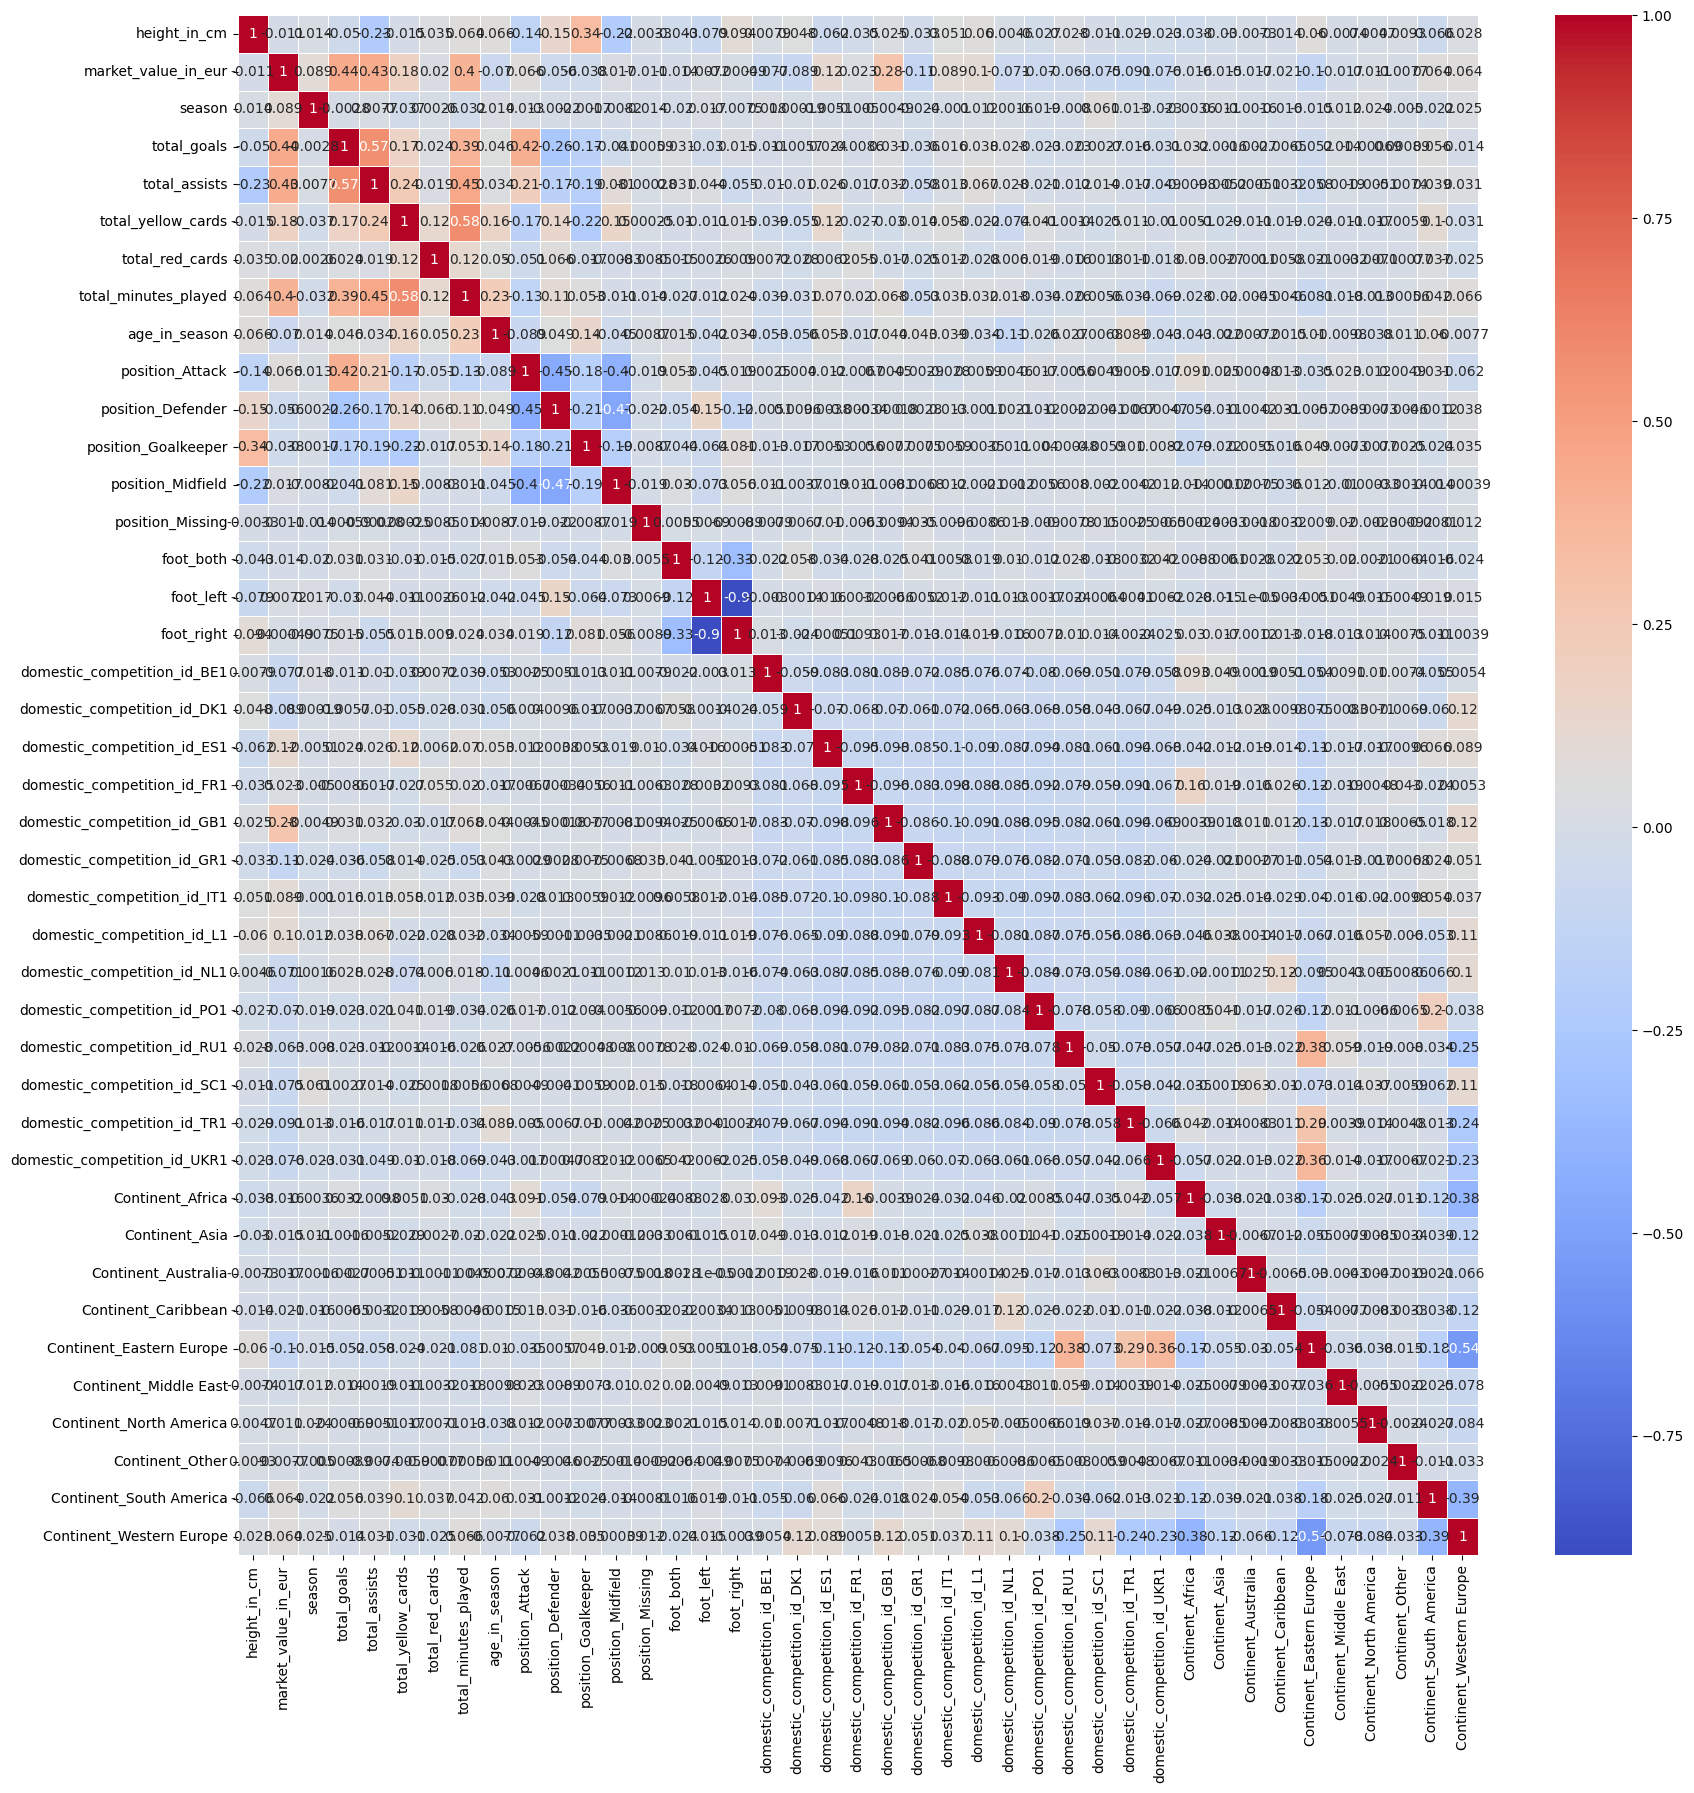

In [206]:
#show the whole correlation matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(20,20))
sns.heatmap(df_encoded.corr(), annot=True, cmap='coolwarm', linewidths=.5)

In [207]:
#show the correlation of the attributes
correlation_matrix = df_encoded.corr()
corr_market_value = correlation_matrix["market_value_in_eur"].sort_values(ascending=False)
corr_market_value = corr_market_value.drop("market_value_in_eur")
print(corr_market_value)

total_goals                     0.443964
total_assists                   0.431821
total_minutes_played            0.398313
domestic_competition_id_GB1     0.280015
total_yellow_cards              0.182191
domestic_competition_id_ES1     0.118021
domestic_competition_id_L1      0.100668
season                          0.089158
domestic_competition_id_IT1     0.088715
position_Attack                 0.065668
Continent_Western Europe        0.064285
Continent_South America         0.063672
domestic_competition_id_FR1     0.023237
total_red_cards                 0.020040
position_Midfield               0.017103
Continent_North America         0.010927
foot_left                       0.007212
foot_right                     -0.000486
Continent_Other                -0.007652
height_in_cm                   -0.010513
position_Missing               -0.010969
foot_both                      -0.014323
Continent_Asia                 -0.014650
Continent_Africa               -0.015648
Continent_Austra

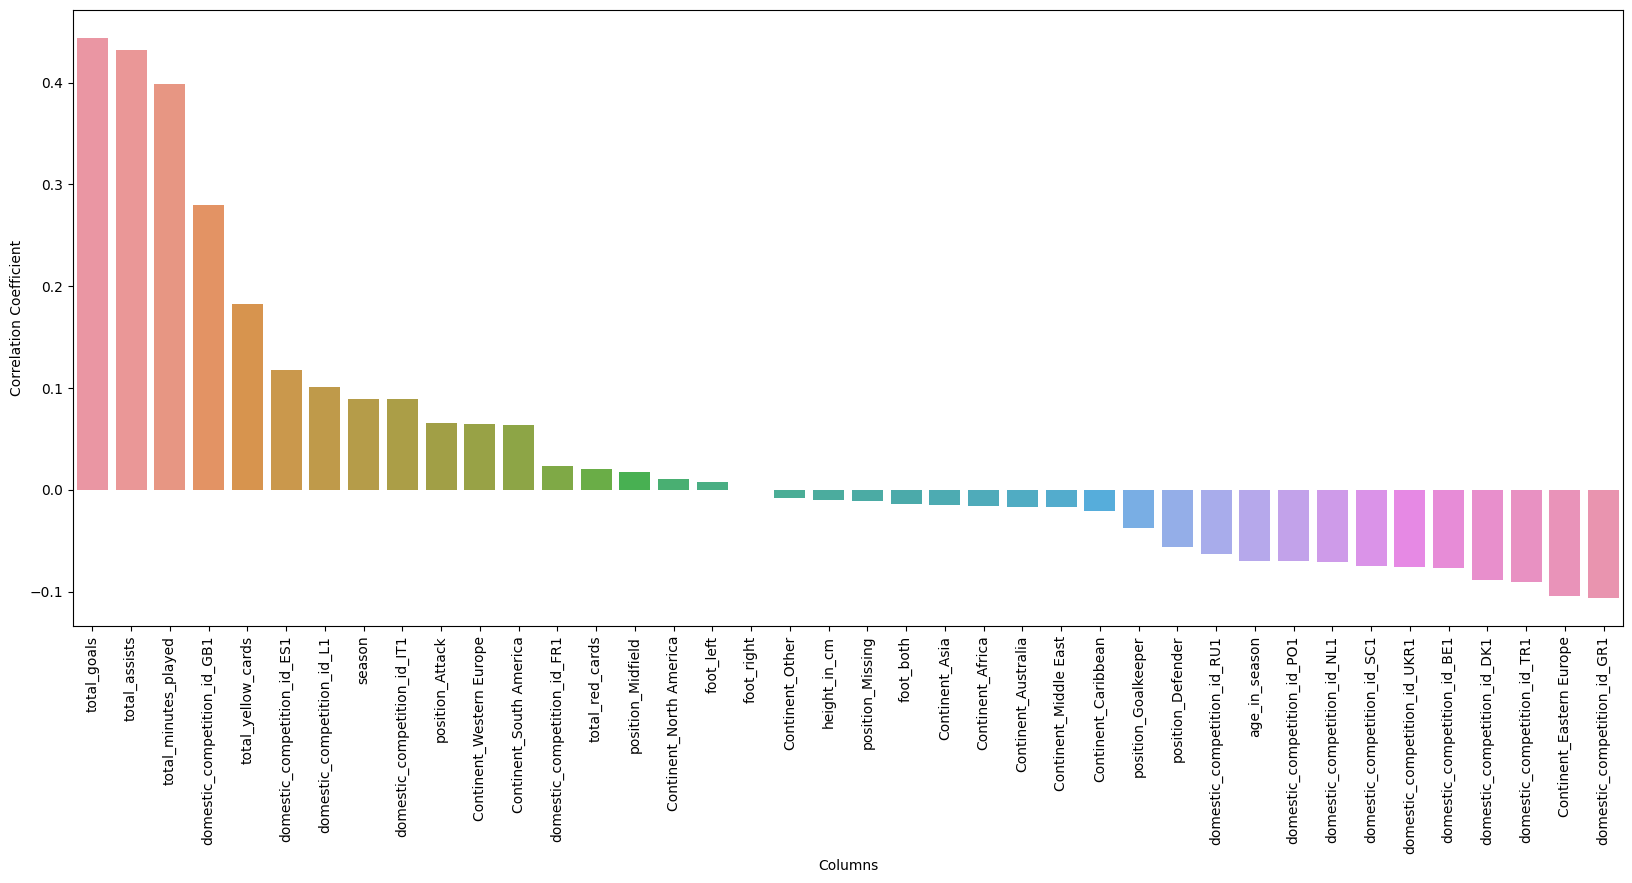

In [208]:
#show the correlation of attributes with market value in a bar chart
plt.figure(figsize=(20,8))
sns.barplot(x=corr_market_value.index, y=corr_market_value.values)
plt.ylabel('Correlation Coefficient')
plt.xlabel('Columns')
# Rotate x-axis labels to 45 degrees
plt.xticks(rotation=90)
plt.show()

In [209]:
df = df_encoded

In [210]:
#train a machine learning model that predicts market value
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# Define the features (X) and the target (y)
X = df.drop('market_value_in_eur', axis=1)
y = df['market_value_in_eur']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the RandomForestRegressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
rf.fit(X_train, y_train)

# Predict on the test set
y_pred = rf.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mae, r2

(2772913.819419984, 0.6502098745206368)